## Preprocessing Script

#### Import Libraries

In [1]:
import os
import pandas as pd
import re
from collections import Counter
from matplotlib import pyplot as plt
import pathlib
import spacy
nlp = spacy.load("en_core_web_sm")

In [2]:
directory = '/Users/soconr/Documents/PhD/SpeechActClassification/SPICE sorted files txt'
register_folders = os.listdir(directory)

In [3]:
def preprocess(directory):
    """Preprocess the text files in the given directory.
    """

    notebook_dir = pathlib.Path().resolve()

    labels = []
    turn_counter = 0
    table = pd.DataFrame()

    print("Folders: ", register_folders)
    for register_folder in register_folders:
        if register_folder.startswith("SPICE"):
            register = register_folder[6:].strip()
            os.chdir(directory+"/"+register_folder)
            print("Current directory 2: ", os.getcwd())
            region_folders = os.listdir()
            print("Folders: ", region_folders)
            for region_folder in region_folders:
                if region_folder.startswith("SPICE"):
                    region = region_folder.strip()[-1]
                    print(os.getcwd())
                    os.chdir(str(os.getcwd())+"/"+region_folder)
                    files = os.listdir()
                    for file in files:
                        if not file.startswith("."):
                            with open(file, encoding="iso-8859-1") as openfile:
                                prev_gold = "NONE"
                                print("OPENING FILE: ", register, region, file)
                                filecontent = openfile.read()

                                turns = filecontent.split("<#>")

                                turn_counter += len(turns)

                                for i in range(len(turns)):
                                    line = turns[i]
                                    line = re.sub(r"^<.*?> ", "", line) #remove speaker label
                                    line = re.sub(r"<#>", "", line)
                                    line = line.strip()
                                    pattern = r"(<(/?[\w]{3}K?)>)\s*(.*?)\s*<(/?[\w]{3}K?)>"
                                    matches = re.findall(pattern, line)
                                    if matches: 
                                        for speech_act in matches:
                                            label = speech_act[0]
                                            label = re.sub(r"K", "", label) #remove Ks from labels 
                                            label = re.sub(r'</?([^>]+)>', r'\1', label)
                                            label = re.sub(r"cir", "dir", label)
                                            label = re.sub(r"xoa", "xpa", label)
                                            label = re.sub(r"</ir>", "</dir>", label)
                                            labels.append(label)
                                            original_text = speech_act[2]
                                            text = original_text.lower()
                                            text = re.sub(r"<&>.*?<\/&>", "", text) #remove editorial comments
                                            #remove unclear + no. of syllables
                                            text = re.sub(r"<unclear>.*?<\/unclear>", "<unclear>", text)
                                            text = re.sub(r"<\/?X>", "", text)
                                            text = re.sub(r"\d*?", "", text)
                                            text = re.sub(r"[\+\%\*@\\\/]", "", text) #remove various symbols
                                            text = re.sub(r"<&\w+?>|<\/&\w+?>", "", text) #remove language tag
                                            text = re.sub(r"<\.>", "", text) #remove opening <.>
                                            text = re.sub(r"<\/\.>", "", text) #remove closing <.>
                                            table = pd.concat([table, pd.DataFrame.from_records([{
                                                "Register": register,
                                                "Dialogue/Monologue": None,
                                                "Register_low_level": None, 
                                                "Region": region,
                                                "Filename": file,
                                                "Original_Text" : original_text,
                                                "Cleaned_Text": text,
                                                "Prev_Text": "None",
                                                "Next_Text": "None",
                                                "Sentence_Length" : 0,
                                                "Label": label,   
                                            }])])
                                            prev_gold = label
                    os.chdir("../")
            os.chdir("../")


    # add previous and next text as features to the dataframe
    table["Prev_Text"] = table["Cleaned_Text"].shift(1)
    table["Next_Text"] = table["Cleaned_Text"].shift(-1)

    # add register information as features to the dataframe

    def add_dia_mono(row):
        if row['Filename'].startswith("P1"):
            return "Dialogue"
        if row['Filename'].startswith("P2"):
            return "Monologue"
        
    def add_register_low(row):
        if row['Filename'].startswith("P1A"):
            return "Private"
        if row['Filename'].startswith("P1B"):
            return "Public"
        if row['Filename'].startswith("P2A"):
            return "Unscripted"
        if row['Filename'].startswith("P2B"):
            return "Scripted"
        

    def greetings(row):
        greetings_dic = ["hello", "hi", "hey", "greetings", 
                 "good morning", "good afternoon", "good evening", 
                 "how are you", "how's it going", "what's up", "howdy",
                 "salutations", "welcome", "thank you", "thanks",
                 "goodbye", "bye", "see you", "take care"]
        for greeting in greetings_dic:
            if greeting in row['Cleaned_Text'].lower():
                return True
        return False
        
    
    def get_pos_tags_and_bigrams(text):
        doc = nlp(text)
        pos_tags = [token.pos_ for token in doc]  # List of POS tags
        pos_bigrams = ["_".join(pair) for pair in zip(pos_tags, pos_tags[1:])]  # Create bigrams
    
        return " ".join(pos_tags), " ".join(pos_bigrams)  # Return as space-separated strings


    table["Dialogue/Monologue"] = table.apply(add_dia_mono, axis=1)
    table["Register_low_level"] = table.apply(add_register_low, axis=1)        
    table[["PoS_Tags", "PoS_Bigrams"]] = table["Cleaned_Text"].apply(lambda x: pd.Series(get_pos_tags_and_bigrams(x)))
    table["Greeting"] = table.apply(greetings, axis=1)
    table["First_Word"] = table["Cleaned_Text"].apply(lambda x: x.split()[0] if isinstance(x, str) and len(x.split()) > 0 else "")

    print("length with duplicates: ", len(table))
    print(table[:9])
    # If cleaned text and label are the same, remove the duplicates
    table_unique = table.drop_duplicates(subset=['Cleaned_Text', 'Label'])

    # add sentence length (in characters) as a feature to the dataframe
    table_unique["Sentence_Length"] = table_unique["Cleaned_Text"].apply(len)

    print("length without duplicates: ", len(table_unique))
    # go to script's directory before writing to files
    os.chdir(os.path.dirname(os.path.abspath("")))
    table_unique.to_csv(notebook_dir / "preprocessed_data.csv")
    #print(table)

    labels = table_unique["Label"]
    labels_count = Counter(labels)
    print("number of turns: ", turn_counter)

    print(set(labels), len(set(labels)), labels_count)                    

    plt.bar(labels_count.keys(), labels_count.values())
    plt.title("Speech Acts Distribution after Preprocessing")
    plt.xlabel("Speech Act")
    plt.ylabel("Occurrences")
    for i, (key, value) in enumerate(labels_count.items()):
        plt.text(i, value + 100, str(value), ha='center', va='bottom')
    plt.savefig(notebook_dir / "Speech_Acts_Distribution.png", dpi=300, bbox_inches="tight")
    plt.show()

Folders:  ['SPICE Legal presentations', 'SPICE Broadcast interview', 'SPICE Telephone conversation', '.DS_Store', 'duplicates.csv', 'count_subtexts.py', 'SPICE Unscripted speeches', 'SPICE Broadcast discussion', 'SPICE Parliamentary debate', 'SPICE Broadcast talks', 'SPICE Scripted speeches', 'SPICE Spontaneous commentary', 'SPICE Legal cross-examination', 'SPICE Business transactions', 'Speech_Acts_DistributionNEW.png', 'preprocessed_data.csv', 'Speech_Acts_Distribution.png', 'SPICE Demonstrations', 'SPICE Classroom discussion', 'SPICE Broadcast news', 'SPICE Face to face conversation']
Current directory 2:  /Users/soconr/Documents/PhD/SpeechActClassification/SPICE sorted files txt/SPICE Legal presentations
Folders:  ['.DS_Store', 'SPICE Legal pres S', 'SPICE Legal pres N']
/Users/soconr/Documents/PhD/SpeechActClassification/SPICE sorted files txt/SPICE Legal presentations
OPENING FILE:  Legal presentations S P2A-070 Banking.txt
OPENING FILE:  Legal presentations S P2A-067 Resignation

/var/folders/30/5j4bybt912x5g1byn87cc0b0c0p4jg/T/ipykernel_36731/162877407.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_unique["Sentence_Length"] = table_unique["Cleaned_Text"].apply(len)


number of turns:  53093
{'icu', 'dir', 'com', 'exp', 'dec', 'soc', 'rep', 'xpa'} 8 Counter({'rep': 32742, 'dir': 9132, 'xpa': 1734, 'exp': 935, 'icu': 678, 'com': 654, 'soc': 93, 'dec': 49})


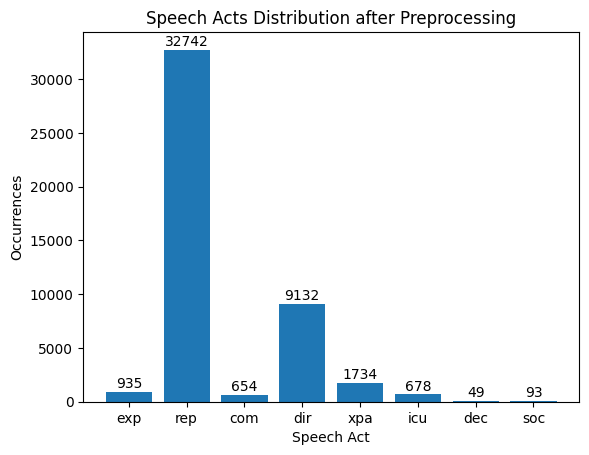

In [4]:
preprocess(directory)